# Experiments with Quantum 

Here are the experiments with the quantum side of things.

In [1]:
# For dataset.
from sklearn.datasets import make_multilabel_classification, make_classification
from qiskit_algorithms.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC, QSVC
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.kernels import BaseKernel, TrainableFidelityQuantumKernel

/var/folders/4z/946_ygn50p3bc_rsjbq9cg240000gn/T/ipykernel_70561/477652652.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import pandas as pd
import abc

In [3]:
# for data split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [4]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap

In [5]:
from qiskit.circuit.library import RealAmplitudes

In [6]:
class quantumAlgoTraining:
    """
    Class to train quantum algorithms for multiclass single label."""
    def __init__(self, no_of_features, no_of_samples, no_of_classes, no_of_feature_map_reps, no_of_ansatz_reps, models = ['knn', 'qda', 'rf', 'lightgbm', 'svm']):
        self.no_of_features = no_of_features
        self.no_of_samples = no_of_samples
        # self.no_of_labels = no_of_labels
        self.no_of_classes = no_of_classes
        self.models = models
        self.featuremap_reps = no_of_feature_map_reps
        self.ansatz_reps = no_of_ansatz_reps
        self.objective_func_vals = []
        print(f"the no of classes is {self.no_of_classes}")

    def data_generation(self):
        """
        Generate classification data using sklearn's data generation.\
        """
        n_samples=self.no_of_samples
        n_features=self.no_of_features
        n_classes=self.no_of_classes
        print(n_samples)
        X, y = make_classification(n_samples=n_samples,
                                   n_features=n_features,
                                   n_classes=n_classes,
                                    n_redundant=0,
                                    n_clusters_per_class=1,
                                    class_sep=2.0,
                                    random_state=algorithm_globals.random_seed
                                    )
        print(f"the number of classses is: {n_classes}")
        return X, y

    # def train_test_split(self):
    #     """
    #     splitting the data into train test split
    #     """
    #     ## Train test split
    #     # X, y = self.data_generation()
    #     train_features, test_features, train_labels, test_labels = train_test_split(
    #         X, y, train_size=0.8, random_state=algorithm_globals.random_seed
    #     )
    #     return train_features, test_features, train_labels, test_labels

    def generate_featuremap(self):
        """ Generating the feature map."""
        feature_map = ZZFeatureMap(feature_dimension=self.no_of_features, reps=self.featuremap_reps)
        return feature_map

    def generate_ansatz(self):
        """Generating ansatz."""
        ansatz = RealAmplitudes(num_qubits=self.no_of_features, reps=self.ansatz_reps)
        return ansatz

    def callback_graph(self, weights, obj_func_eval):
        clear_output(wait=True)
        self.objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(self.objective_func_vals)), self.objective_func_vals)
        plt.show()
    
    def quantum_training(self):
        X, y = self.data_generation()
        print(X.shape, y.shape)
        optimizer = COBYLA(maxiter=100)
        model = 'VQC'
        results = {}
        vqc = VQC(
            # sampler=sampler,
            feature_map=self.generate_featuremap(),
            ansatz=self.generate_ansatz(),
            loss='cross_entropy',
            optimizer=optimizer,
            callback=self.callback_graph,
        )
        
        # clear objective value history
        objective_func_vals = []
        
        start = time.time()
        vqc.fit(X, y)
        elapsed = time.time() - start
        
        print(f"Training time: {round(elapsed)} seconds")
        # testing the QSVC scores
        predictions = vqc.predict(X)
        accuracy = accuracy_score(y, predictions)
        f1score = f1_score(y, predictions)
        results.setdefault('Model', []).append(model)
        results.setdefault('No of features', []).append(self.no_of_features)
        results.setdefault('No of samples', []).append(self.no_of_samples)
        results.setdefault('No of classes', []).append(self.no_of_classes)
        results.setdefault('No of feature map reps', []).append(self.featuremap_reps)
        results.setdefault('No of ansatz reps', []).append(self.ansatz_reps)
        results.setdefault('Accuracy', []).append(accuracy)
        results.setdefault('F1', []).append(f1score)
        
        df = pd.DataFrame(results)
        df.to_csv(f'''results/Quantum-MC-SL-features_{self.no_of_features}-samples_{self.no_of_samples}-classes_{self.no_of_classes}-featuremapReps_{self.featuremap_reps}-ansatzReps_{self.ansatz_reps}.csv''', index=False)
        return df

----

# ML MC Quantum Training


In [7]:
class quantumMultiLabelAlgoTrainingVQC:
    """
    Class to train quantum algorithms for multiclass multilabel.
    """
    def __init__(self, no_of_features, no_of_samples, no_of_classes, no_of_labels, no_of_feature_map_reps, no_of_ansatz_reps, models = ['knn', 'qda', 'rf', 'lightgbm', 'svm']):
        self.no_of_features = no_of_features
        self.no_of_samples = no_of_samples
        self.no_of_labels = no_of_labels
        self.no_of_classes = no_of_classes
        self.models = models
        self.featuremap_reps = no_of_feature_map_reps
        self.ansatz_reps = no_of_ansatz_reps
        self.objective_func_vals = []
        print(f"the no of classes is {self.no_of_classes}")

    def data_generation(self):
        """
        Generate classification data using sklearn's data generation.\
        """
        n_samples=self.no_of_samples
        n_features=self.no_of_features
        n_classes=self.no_of_classes
        n_labels=self.no_of_labels
        print(n_samples)
        X, y = make_multilabel_classification(n_samples=n_samples, 
                                              n_features=n_features, 
                                              n_classes=n_classes, 
                                              n_labels=n_labels,
                                              random_state=algorithm_globals.random_seed
                                             )
        y_new = np.array([self.conv_to_int(val) for val in y])
        # y_new = y[:,0]*(2**4)+y[:,1]*(2**3)+y[:,2]*(2**2)+y[:,3]*(2**1)+y[:,4]*(2**0)
        # y_new = y[:,0]*(2**2)+y[:,1]*(2**1)+y[:,2]*(2**0)
        # y_new = y[:,0]*(2**1)+y[:,1]*(2**0)
        print(X.shape, y.shape, y_new.shape)
        print(X[:5], y[:5], y_new[:5])
        return X, y, y_new

    def int_to_hot(self, x):
        format = '{' + '0:0{:d}b'.format(self.no_of_classes) + '}'
        result = format.format(x)
        list_of_ints = [int(x) for x in result]
        return np.array(list_of_ints)

    def get_mapping(self):
        dictionary = {}
        numbers = list(range(0, 2**self.no_of_classes))
        for i in numbers:
            dictionary[i] = self.int_to_hot(i)
        return dictionary

    def conv_to_int(self, vector):
        val = "".join(vector.astype(str))
        value = int(val, 2)
        return value

    def get_mapping_old(self):
        mapping = {0: [0, 0, 0, 0, 0], 1: [0, 0, 0, 0, 1], 2: [0, 0, 0, 1, 0], 3: [0, 0, 0, 1, 1], 4: [0, 0, 1, 0, 0], 5: [0, 0, 1, 0, 1], 6: [0, 0, 1, 1, 0], 7: [0, 0, 1, 1, 1], 8: [0, 1, 0, 0, 0], 9: [0, 1, 0, 0, 1], 10: [0, 1, 0, 1, 0], 11: [0, 1, 0, 1, 1], 12: [0, 1, 1, 0, 0], 13: [0, 1, 1, 0, 1], 14: [0, 1, 1, 1, 0], 15: [0, 1, 1, 1, 1], 16: [1, 0, 0, 0, 0], 17: [1, 0, 0, 0, 1], 18: [1, 0, 0, 1, 0], 19: [1, 0, 0, 1, 1], 20: [1, 0, 1, 0, 0], 21: [1, 0, 1, 0, 1], 22: [1, 0, 1, 1, 0], 23: [1, 0, 1, 1, 1], 24: [1, 1, 0, 0, 0], 25: [1, 1, 0, 0, 1], 26: [1, 1, 0, 1, 0], 27: [1, 1, 0, 1, 1], 28: [1, 1, 1, 0, 0], 29: [1, 1, 1, 0, 1], 30: [1, 1, 1, 1, 0], 31: [1, 1, 1, 1, 1]}
        return mapping
        # mapping = {0: [0,0,0], 1: [0,0,1], 2:[0,1,0], 3:[0,1,1], 4:[1, 0, 0], 5:[1, 0, 1], 6:[1, 1, 0], 7:[1, 1, 1]}
        # mapping = {0: [0,0], 1: [0,1], 2: [1,0], 3:[1,1]}

    # def train_test_split(self):
    #     """
    #     splitting the data into train test split
    #     """
    #     ## Train test split
    #     # X, y = self.data_generation()
    #     train_features, test_features, train_labels, test_labels = train_test_split(
    #         X, y, train_size=0.8, random_state=algorithm_globals.random_seed
    #     )
    #     return train_features, test_features, train_labels, test_labels

    def generate_featuremap(self):
        """ Generating the feature map."""
        feature_map = ZZFeatureMap(feature_dimension=self.no_of_features, reps=self.featuremap_reps)
        return feature_map

    def generate_ansatz(self):
        """Generating ansatz."""
        ansatz = RealAmplitudes(num_qubits=self.no_of_features, reps=self.ansatz_reps)
        return ansatz

    def callback_graph(self, weights, obj_func_eval):
        clear_output(wait=True)
        self.objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(self.objective_func_vals)), self.objective_func_vals)
        plt.show()

    def quantum_training(self):
        X, y, y_new = self.data_generation()
        print(X.shape, y.shape, y_new.shape)
        # best_model = compare_models(include=self.models, sort='f1')
        # print(best_model)
        mapping = self.get_mapping()
        optimizer = COBYLA(maxiter=50)
        model = 'VQC'
        vqc = VQC(
            # sampler=sampler,
            feature_map=self.generate_featuremap(),
            ansatz=self.generate_ansatz(),
            loss='cross_entropy',
            optimizer=optimizer,
            callback=self.callback_graph,
        )
        
        # clear objective value history
        objective_func_vals = []
        
        start = time.time()
        vqc.fit(X, y_new)
        elapsed = time.time() - start
        
        print(f"Training time: {round(elapsed)} seconds")
        # testing the QSVC scores
        predictions = vqc.predict(X)

        # Use list comprehension to create the new array
        print(f"The type of predictions is: {type(predictions)}")
        predictions_labels_final = np.array([mapping[val] for val in predictions])
        print(y.shape, predictions_labels_final.shape)
        print(predictions_labels_final[:5])
        accuracy_scores = accuracy_score(y, predictions_labels_final)
        f1_scores = f1_score(y, predictions_labels_final, average='weighted')
        results.setdefault('Model', []).append(model)
        results.setdefault('No of features', []).append(self.no_of_features)
        results.setdefault('No of samples', []).append(self.no_of_samples)
        results.setdefault('No of classes', []).append(self.no_of_classes)
        results.setdefault('No of labels', []).append(self.no_of_labels)
        results.setdefault('No of feature map reps', []).append(self.featuremap_reps)
        results.setdefault('No of ansatz reps', []).append(self.ansatz_reps)
        results.setdefault('Accuracy', []).append(accuracy_scores)
        results.setdefault('F1', []).append(f1_scores)
        results.setdefault('Time taken', []).append(elapsed)
        # df = pd.DataFrame(results)
        # df.to_csv(f'''results/Quantum-MC-ML-features_{self.no_of_features}-samples_{self.no_of_samples}-classes_{self.no_of_classes}-labels_{self.no_of_labels}-featuremapReps_{self.featuremap_reps}-ansatzReps_{self.ansatz_reps}.csv''', index=False)
        # return df

In [8]:
results = {}
no_of_features = [12,16]
no_of_samples = [1024]
no_of_classes = [3]
no_of_labels = [3]
no_of_feature_map_reps = [3]
no_of_ansatz_reps = [3]

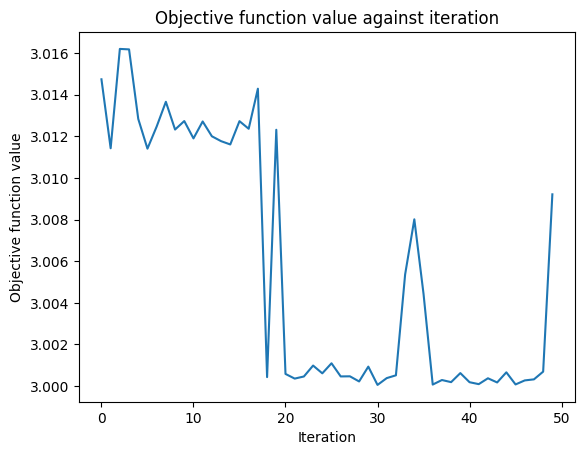

Training time: 131430 seconds
The type of predictions is: <class 'numpy.ndarray'>
(1024, 3) (1024, 3)
[[0 0 0]
 [0 0 0]
 [0 1 0]
 [1 1 1]
 [1 0 0]]


In [9]:
for feature in no_of_features:
    for sample in no_of_samples:
        for featuremap_reps in no_of_feature_map_reps:
            for ansatz_reps in no_of_ansatz_reps:
                for clas in no_of_classes:
                    for lab in no_of_labels:
                        if lab <= clas:
                            
                            training_object = quantumMultiLabelAlgoTrainingVQC(feature, sample, clas, lab, featuremap_reps, ansatz_reps)
                            training_object.quantum_training()

In [10]:
df = pd.DataFrame(results)
df.to_csv(f'''results/Final/for-writing/QuantumVQC-MC-ML-experiments.csv''', index=False)

-----

## Part for QSVC

In [152]:
class MyBaseKernel(BaseKernel):
    def evaluate(self, X, y):
        pass

In [178]:
class quantumMultiLabelAlgoTrainingQSVC(abc.ABC):
    """
    Class to train quantum algorithms for multiclass multilabel.
    """
    __metaclass__ = abc.ABCMeta
    
    def __init__(self, no_of_features, no_of_samples, no_of_classes, no_of_labels, no_of_feature_map_reps, no_of_ansatz_reps, models = ['knn', 'qda', 'rf', 'lightgbm', 'svm']):
        # super().__init__()
        self.no_of_features = no_of_features
        self.no_of_samples = no_of_samples
        self.no_of_labels = no_of_labels
        self.no_of_classes = no_of_classes
        self.models = models
        self.featuremap_reps = no_of_feature_map_reps
        self.ansatz_reps = no_of_ansatz_reps
        self.objective_func_vals = []
        print(f"the no of classes is {self.no_of_classes}")
        # self.basekernel = MyBaseKernel

    def data_generation(self):
        """
        Generate classification data using sklearn's data generation.\
        """
        n_samples=self.no_of_samples
        n_features=self.no_of_features
        n_classes=self.no_of_classes
        n_labels=self.no_of_labels
        print(n_samples)
        X, y = make_multilabel_classification(n_samples=n_samples, 
                                              n_features=n_features, 
                                              n_classes=n_classes, 
                                              n_labels=n_labels,
                                              random_state=algorithm_globals.random_seed
                                             )
        y_new = np.array([self.conv_to_int(val) for val in y])
        # y_new = y[:,0]*(2**4)+y[:,1]*(2**3)+y[:,2]*(2**2)+y[:,3]*(2**1)+y[:,4]*(2**0)
        # y_new = y[:,0]*(2**2)+y[:,1]*(2**1)+y[:,2]*(2**0)
        # y_new = y[:,0]*(2**1)+y[:,1]*(2**0)
        print(X.shape, y.shape, y_new.shape)
        print(X[:5], y[:5], y_new[:5])
        return X, y, y_new

    def int_to_hot(self, x):
        format = '{' + '0:0{:d}b'.format(self.no_of_classes) + '}'
        result = format.format(x)
        list_of_ints = [int(x) for x in result]
        return np.array(list_of_ints)

    def get_mapping(self):
        dictionary = {}
        numbers = list(range(0, 2**self.no_of_classes))
        for i in numbers:
            dictionary[i] = self.int_to_hot(i)
        return dictionary

    def conv_to_int(self, vector):
        val = "".join(vector.astype(str))
        value = int(val, 2)
        return value

    def get_mapping_old(self):
        mapping = {0: [0, 0, 0, 0, 0], 1: [0, 0, 0, 0, 1], 2: [0, 0, 0, 1, 0], 3: [0, 0, 0, 1, 1], 4: [0, 0, 1, 0, 0], 5: [0, 0, 1, 0, 1], 6: [0, 0, 1, 1, 0], 7: [0, 0, 1, 1, 1], 8: [0, 1, 0, 0, 0], 9: [0, 1, 0, 0, 1], 10: [0, 1, 0, 1, 0], 11: [0, 1, 0, 1, 1], 12: [0, 1, 1, 0, 0], 13: [0, 1, 1, 0, 1], 14: [0, 1, 1, 1, 0], 15: [0, 1, 1, 1, 1], 16: [1, 0, 0, 0, 0], 17: [1, 0, 0, 0, 1], 18: [1, 0, 0, 1, 0], 19: [1, 0, 0, 1, 1], 20: [1, 0, 1, 0, 0], 21: [1, 0, 1, 0, 1], 22: [1, 0, 1, 1, 0], 23: [1, 0, 1, 1, 1], 24: [1, 1, 0, 0, 0], 25: [1, 1, 0, 0, 1], 26: [1, 1, 0, 1, 0], 27: [1, 1, 0, 1, 1], 28: [1, 1, 1, 0, 0], 29: [1, 1, 1, 0, 1], 30: [1, 1, 1, 1, 0], 31: [1, 1, 1, 1, 1]}
        return mapping
        # mapping = {0: [0,0,0], 1: [0,0,1], 2:[0,1,0], 3:[0,1,1], 4:[1, 0, 0], 5:[1, 0, 1], 6:[1, 1, 0], 7:[1, 1, 1]}
        # mapping = {0: [0,0], 1: [0,1], 2: [1,0], 3:[1,1]}

    # def train_test_split(self):
    #     """
    #     splitting the data into train test split
    #     """
    #     ## Train test split
    #     # X, y = self.data_generation()
    #     train_features, test_features, train_labels, test_labels = train_test_split(
    #         X, y, train_size=0.8, random_state=algorithm_globals.random_seed
    #     )
    #     return train_features, test_features, train_labels, test_labels

    def generate_featuremap(self):
        """ Generating the feature map."""
        feature_map = ZZFeatureMap(feature_dimension=self.no_of_features, reps=self.featuremap_reps)
        return feature_map

    def generate_ansatz(self):
        """Generating ansatz."""
        ansatz = RealAmplitudes(num_qubits=self.no_of_features, reps=self.ansatz_reps)
        return ansatz

    def callback_graph(self, weights, obj_func_eval):
        clear_output(wait=True)
        self.objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(self.objective_func_vals)), self.objective_func_vals)
        plt.show()
        

    # def get_basekernel(self):
    #     basekernel = BaseKernel()
        
    #     return basekernel
        

    def quantum_training(self):
        X, y, y_new = self.data_generation()
        print(X.shape, y.shape, y_new.shape)
        # best_model = compare_models(include=self.models, sort='f1')
        # print(best_model)
        mapping = self.get_mapping()
        optimizer = COBYLA(maxiter=10)
        # feature_map=self.generate_featuremap()
        # kernel = kernel_instance()
        model = 'QSVC'
        # quantum_kernel=MyBaseKernel(feature_map=self.generate_featuremap())
        # quantum_kernel=TrainableFidelityQuantumKernel(feature_map=self.generate_featuremap(), training_parameters=self.generate_featuremap().parameters)
        # quantum_trainer = QuantumKernelTrainer(quantum_kernel=quantum_kernel)
        # qka_results = quantum_trainer.fit(X, y_new)
        # optimized_kernel = qka_results.quantum_kernel
        qsvc = QSVC()
        
        # clear objective value history
        objective_func_vals = []
        
        start = time.time()
        qsvc.fit(X, y_new)
        elapsed = time.time() - start
        
        print(f"Training time: {round(elapsed)} seconds")
        # testing the QSVC scores
        predictions = qsvc.predict(X)

        # Use list comprehension to create the new array
        # print(f"The type of predictions is: {type(predictions)}")
        predictions_labels_final = np.array([mapping[val] for val in predictions])
        print(y.shape, predictions_labels_final.shape)
        print(predictions_labels_final[:5])
        accuracy_scores = accuracy_score(y, predictions_labels_final)
        f1_scores = f1_score(y, predictions_labels_final, average='weighted')
        results.setdefault('Model', []).append(model)
        results.setdefault('No of features', []).append(self.no_of_features)
        results.setdefault('No of samples', []).append(self.no_of_samples)
        results.setdefault('No of classes', []).append(self.no_of_classes)
        results.setdefault('No of labels', []).append(self.no_of_labels)
        results.setdefault('No of feature map reps', []).append(self.featuremap_reps)
        results.setdefault('No of ansatz reps', []).append(self.ansatz_reps)
        results.setdefault('Accuracy', []).append(accuracy_scores)
        results.setdefault('F1', []).append(f1_scores)
        # df = pd.DataFrame(results)
        # df.to_csv(f'''results/Quantum-MC-ML-features_{self.no_of_features}-samples_{self.no_of_samples}-classes_{self.no_of_classes}-labels_{self.no_of_labels}-featuremapReps_{self.featuremap_reps}-ansatzReps_{self.ansatz_reps}.csv''', index=False)
        # return df

no_of_features = [2, 4, 6, 8, 16]
no_of_samples = [64, 512, 2048]
no_of_classes = [2, 3, 4, 5]
no_of_labels = [2, 3, 4, 5]
no_of_feature_map_reps = [2, 3, 4, 5]
no_of_ansatz_reps = [2, 3, 4, 5]

In [179]:
no_of_features = [7]
no_of_samples = [2048]
no_of_classes = [5]
no_of_labels = [5]
no_of_feature_map_reps = [3]
no_of_ansatz_reps = [3]

In [180]:
for lab in no_of_labels:
    for clas in no_of_classes:
        for feature in no_of_features:
            for sample in no_of_samples:
                for featuremap_reps in no_of_feature_map_reps:
                    for ansatz_reps in no_of_ansatz_reps:
                        training_object = quantumMultiLabelAlgoTrainingVQC(feature, sample, clas, lab, featuremap_reps, ansatz_reps)
                        training_object.quantum_training()

NameError: name 'quantumMultiLabelAlgoTrainingVQC' is not defined

In [13]:
df = pd.DataFrame(results)
df.to_csv(f'''results/Quantum-VQC-MC-ML-experiments.csv''', index=False)

In [181]:
for lab in no_of_labels:
    for clas in no_of_classes:
        for feature in no_of_features:
            for sample in no_of_samples:
                for featuremap_reps in no_of_feature_map_reps:
                    for ansatz_reps in no_of_ansatz_reps:
                        training_object = quantumMultiLabelAlgoTrainingQSVC(feature, sample, clas, lab, featuremap_reps, ansatz_reps)
                        training_object.quantum_training()

the no of classes is 5
2048
(2048, 7) (2048, 5) (2048,)
[[ 9. 10.  8.  9.  7.  6.  6.]
 [ 8. 12.  7. 12.  2. 11.  6.]
 [ 9.  5. 11.  7.  7.  7.  9.]
 [ 4.  5.  3. 10.  6.  6.  9.]
 [ 9.  9.  8.  8.  7.  3.  6.]] [[1 1 1 1 1]
 [1 0 1 0 0]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [1 1 1 1 1]] [31 20 29 31 31]
(2048, 7) (2048, 5) (2048,)


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(results)
df.to_csv(f'''results/QuantumQSVC-MC-ML-experiments.csv''', index=False)